# Preliminaries

In [1]:
import numpy as np
from numpy import random as rd
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.rcParams['figure.figsize'] = [10, 6]

# Supplied code:

from numpy import pi, sqrt, log, exp

#
# Normal cumulative distribution function, with extension
# for complex argument with small imaginary component
#


def norm_cdf(x):
    if not isinstance(x, np.ndarray):
        xr = x.real
        xi = x.imag
        if abs(xi) > 1.0e-10:
            raise ValueError("imag(x) too large in norm_cdf(x)")

        ncf = norm.cdf(xr)
        if abs(xi) > 0:
            ncf = ncf + 1.0j * xi * norm.pdf(xr)
    else:
        xr = np.real(x)
        xi = np.imag(x)
        if any(abs(xi) > 1.0e-10):
            raise ValueError("imag(x) too large in norm_cdf(x)")

        ncf = norm.cdf(xr)
        if any(abs(xi) > 0):
            ncf = ncf + 1.0j * xi * norm.pdf(xr)

    return ncf


# V = european_call(r,sigma,T,S,K,opt)
#
# Black-Scholes European call option solution
# as defined in equation (3.17) on page 48 of
# The Mathematics of Financial Derivatives
# by Wilmott, Howison and Dewynne
#
# r     - interest rate
# sigma - volatility
# T     - time interval
# S     - asset value(s)  (float or flattened numpy array)
# K     - strike price(s) (float or flattened numpy array)
# opt   - 'value', 'delta', 'gamma' or 'vega'
# V     - option value(s) (float or flattened numpy array)
#


def european_call(r, sigma, T, S, K, opt):

    S = S + 1.0e-100  # avoids problems with S=0
    K = K + 1.0e-100  # avoids problems with K=0

    d1 = (log(S) - log(K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S) - log(K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))

    if opt == "value":
        V = S * norm_cdf(d1) - exp(-r * T) * K * norm_cdf(d2)
    elif opt == "delta":
        V = norm_cdf(d1)
    elif opt == "gamma":
        V = exp(-0.5 * d1 ** 2) / (sigma * sqrt(2 * pi * T) * S)
    elif opt == "vega":
        V = S * (exp(-0.5 * d1 ** 2) / sqrt(2 * pi)) * (sqrt(T) - d1 / sigma) - exp(
            -r * T
        ) * K * (exp(-0.5 * d2 ** 2) / sqrt(2 * pi)) * (-sqrt(T) - d2 / sigma)

    else:
        raise ValueError(
            'invalid value for opt -- must be "value", "delta", "gamma", "vega"'
        )

    return V

# Weak convergence - comparison with exact solution

In [ ]:
#
# Test weak convergence of Euler method
# for European call option
#
# Test problem:   dS   = r*S dt + sig*S dW
#

#
# problem parameters and exact solution
#

r, sig, T, S0, K = 0.05, 0.5, 1, 100, 110

Ve  = european_call(r,sig,T,S0,K,'value')

def european_call_payoff(S):
    return np.exp(-r*T) * np.maximum(S - K, 0)

#
# Monte Carlo simulation comparing to exact solution 
#

M  = 10 ** 7   # total number of Monte Carlo paths, not using 10e7 notation to keep M an int
M2 = 10 ** 4   # number of paths at a time, set in accordance with memory available

hh, err1, err2 = np.empty(0), np.empty(0), np.empty(0)

for p in range(1, 7):
    N = 2**p # number of time steps
    h = T/N # time step size

    sum1 = 0 # sum of estimates
    sum2 = 0 # sum of squares estimates
    

    for m in range(0, M, M2):
        m2 = min(M2, M - m)
        # m keeps track of the number of paths already simulated.
        # m2 is the number of paths to simulate this loop.
        # Note m2 will be equal to M2 apart from the last loop,
        # where we use only enough paths to get exactly M paths in total.
        
        S = S0 * np.ones(m2)
        
        for _ in range(N):
            dW = np.sqrt(h)*rd.randn(m2)
            S  = S*(1+r*h+sig*dW)   

        P = european_call_payoff(S)

        sum1 = sum1 + np.sum(P)
        sum2 = sum2 + np.sum(P**2)

    V  = sum1/M
    sd = np.sqrt((sum2/M - V**2)/(M-1))

    hh, err1, err2 = np.append(hh,h), np.append(err1,V-Ve), np.append(err2,3*sd)

In [ ]:
plt.loglog(hh, np.abs(err1), label="Weak Error")
plt.loglog(hh, err2, label="MC Error")
plt.title("Weak convergence -- comparison to exact solution")
plt.xlabel("h")
plt.ylabel("Error")
plt.legend(loc="lower right")
plt.show()

# Weak error - comparison between $2h$ and $h$ path

In [ ]:
#
# Monte Carlo simulation comparing to 2h simulaton 
#

M  = 10**7   # total number of Monte Carlo paths
M2 = 10**4   # number of paths at a time 

hh, err1, err2 = np.empty(0), np.empty(0), np.empty(0)

for p in range(1, 8):
    N = 2**p
    h = T/N

    sum1 = 0 # sum of difference between processes with step sizes 2h and h
    sum2 = 0 # sum of square differences between processes with step sizes 2h and h

    for m in range(0, M, M2):
        m2 = min(M2, M-m)
        
        S, S2 = S0*np.ones(m2), S0*np.ones(m2)
        
        for _ in range(N//2):
            dW1 = np.sqrt(h)*rd.randn(m2)
            S  = S*(1+r*h+sig*dW1)
            dW2 = np.sqrt(h)*rd.randn(m2)
            S  = S*(1+r*h+sig*dW2)
            
            S2  = S2*(1+r*2*h+sig*(dW1+dW2))
            
        P = european_call_payoff(S)
        P2 = european_call_payoff(S2)

        sum1 = sum1 + np.sum(P-P2)
        sum2 = sum2 + np.sum((P-P2)**2)

    Vd  = sum1/M
    sd = np.sqrt((sum2/M - (sum1/M)**2)/(M-1))

    hh, err1, err2 = np.append(hh,h), np.append(err1,Vd), np.append(err2,3*sd)

In [ ]:
plt.loglog(hh, np.abs(err1), label="Weak Error")
plt.loglog(hh, err2, label="MC Error")
plt.title("Weak convergence -- difference from 2h approximation")
plt.xlabel("h")
plt.ylabel("Error")
plt.legend(loc="lower right")
plt.show()

# Strong Error

In [ ]:
#
# Test strong convergence of Euler method
# for solving stochastic o.d.e.'s
#
# Test problem:   dS   = r*S dt + sig*S dW
# Exact solution: S(1) = S(0)*exp((r-0.5*sig^2)+sig*W(1))
#

#
# problem parameters
#

[r, sig, T, S0]   = [0.05, 0.5, 1, 100] 

#
# Monte Carlo simulation comparing to 2h simulation
#

M  = 1e5   # total number of Monte Carlo paths
M2 = 1e4   # number of paths at a time 

def geo_bm_sde(S, m):
    drift_term = r * S
    diffusion_term = np.expand_dims(sig * S, axis=2)
    
def exact_soln(W):
    return S0 * np.exp((r - 0.5 * sig**2) + sig * W)

hh = np.empty(0)
strong_errors_exact = np.empty(0)
strong_errors_exact_mc = np.empty(0)
strong_errors_comparitive = np.empty(0)
strong_errors_comparitive_mx = np.empty(0)
    
for p in range(1, 8):
    N = 2**p
    h = T/N
    
    strong_errors_ex, strong_errors_ex_mc
        = euler_maruyama(geom_bm_sde, S0, T, N, M, paths_per_loop = M2,
                         exact_soln = exact_soln)
    
    strong_errors_comp, strong_errors_comp_mc
        = euler_maruyama(geom_bm_sde, S0, T, N, M, paths_per_loop = M2)
        
    hh = np.append(hh, h)
    strong_errors_ex = np.append(strong_errors_ex)

In [ ]:
plt.loglog(hh, np.abs(err1), label="Exact Error")
plt.loglog(hh, err2, label="MC Error")
plt.loglog(hh, np.abs(err3), label="Relative Error")
plt.loglog(hh, err4, label="MC Error")
plt.title("Strong convergence -- difference from 2h approximation")
plt.xlabel("h")
plt.ylabel("Error")
plt.legend(loc="lower right")
plt.show()

#  Ornstein-Uhlenbeck Process

In [87]:
def euler_maruyama(sde,
                   initial_value, terminal_time, steps, paths,
                   paths_per_loop = None,
                   soln_dim = 1, driving_dim = 1,
                   brownian_cov = None,
                   exact_soln = None):
    
    """
    Simulates the solution S of the SDE
    dS = a(S)*dt + b(S)*dW
    where a is a drift term and b is a diffusion term started from S[0]. We use the
    Euler-Maruyama approximation scheme to numerically solve the SDE. Returns an
    approximation of the strong error.
    
    Parameters
    ----------
    sde :
        returns the drift and diffusion terms
    initial_value :
        The initial value S[0] of the path
    terminal_tume :
        The terminal time T the payoff is based on
    steps :
        The number of steps to use the Euler-Maruyama approximation scheme
    soln_dim :
        The dimensions of the SDE solution
    driving_dim :
        The dimensions of the driving Brownian motion
    brownian_cov :
        A matrix for the covariance of the Brownian paths. Theoretically unnecessary
        as it can be incorporated into the diffusion term, but practically it's
        convenient as it's a common type of coupling. Defaults to no coupling.
    exact_soln :
        A function which generates the exact solution from the terminal value
        of the Brownian path. If this exists we return also strong errors
        compared to the exact value.

    Returns
    -------
    float :
        Estimated strong error
    float :
        Estimated sd of the strong error estimator
    """
    
    N = steps
    T = terminal_time
    h = T/N
    M = paths
    if paths_per_loop == None:
        M2 = M
    else:
        M2 = paths_per_loop
        
    if not brownian_cov is None:
        L = np.linalg.cholesky(brownian_cov)
    
    def update(S, m, h, dW):
        drift_term, diffusion_term = sde(S, m)
        
        if not brownian_cov is None:
            dW = L @ dW
                    
        return S + drift_term * h + np.squeeze(diffusion_term @ dW, axis=2)
        """ Let m be the number of paths. Then our Brownian paths are generated as a
        m * drive_dim * 1 arrays. This is so @ infers the correct matrix multiplication
        when multiplying with m * soln_dim * drive_dim array. However the drift term is a
        m * soln_dim array. So when adding the terms we strip away the final dimension with
        numpy.squeeze"""

    sum1, sum2 = 0, 0

    for m in range(0, M, M2):
        m2 = min(M2, M - m)
        
        S1 = initial_value*np.ones((m2, soln_dim))
        S2 = initial_value*np.ones((m2, soln_dim))
        W = np.zeros((m2, driving_dim, 1))
        
        for _ in range(N//2):
            dW1 = np.sqrt(h) * rd.randn(m2, driving_dim, 1)
            dW2 = np.sqrt(h) * rd.randn(m2, driving_dim, 1)
            
            S1 = update(S1, m2, h, dW1)
            S1 = update(S1, m2, h, dW2)
            S2 = update(S2, m2, 2*h, dW1 + dW2)      
            W += dW1 + dW2
        
        if exact_soln != None:
            Se = exact_soln(np.squeeze(W, axis=2))
            diff = np.sum((Se - S1)**2, axis=1) # L2 squared distance between exact and approximate
        else:
            diff = np.sum((S2 - S1)**2, axis=1)
            
        sum1 += np.sum(diff)
        sum2 += np.sum(diff**2)
        
    strong_error  = sum1/M
    sd = np.sqrt((sum2/M - (sum1/M)**2)/(M-1))
    
    return strong_error, sd

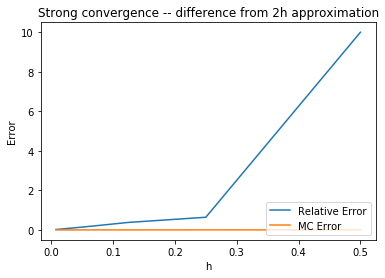

In [82]:
#
# Test strong convergence of Euler method
# for solving stochastic o.d.e.'s
#
# Test problem:   dS   = kappa*(theta - S) dt + sig*dW
#

#
# problem parameters
# 

[kappa, theta, T, S0, sig]   = [2, 110, 1, 100, 0.5] 

#
# Monte Carlo simulation comparing to 2h simulation
#

def ornstein_sde(S, m):
    return kappa * (theta - S), sig * np.ones((m, 1, 1))

M  = 10 ** 5   # total number of Monte Carlo paths
M2 = 10 ** 4   # number of paths at a time 

hh, errors, mc_errors = np.empty(0), np.empty(0), np.empty(0)

for p in range(1, 8):
    N = 2**p
    h = T/N

    error_sq, sd = euler_maruyama(ornstein_sde, S0, T, N, M, paths_per_loop=M2)
        
    hh = np.append(hh,h)
    errors = np.append(errors, np.sqrt(error_sq))
    mc_errors = np.append(mc_errors, 0.5 *3*sd / sqrt(error_sq))

plt.plot(hh, errors, label="Relative Error")
plt.plot(hh, mc_errors, label="MC Error")
plt.title("Strong convergence -- difference from 2h approximation")
plt.xlabel("h")
plt.ylabel("Error")
plt.legend(loc="lower right")
plt.show()

## Heston Model

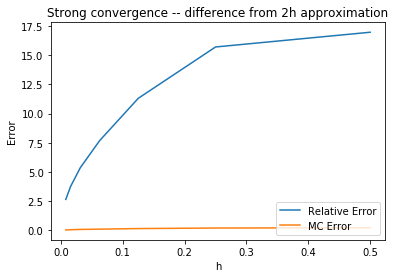

In [89]:
#
# Test strong convergence of Euler method
# for solving stochastic o.d.e.'s
#
# Test problem:   dS   = r*S dt + sqrt(abs(v))*S dW1
#                 dv   = kappa*(theta-v)dt + xi*sqrt(abs(v))*(rho dW1 + sqrt(1-rho**2) dW2
# where W1 and W2 are independent Brownian motions.
#

#
# problem parameters
#

[kappa, theta, T, S0, v0, xi, rho, r]   = [2, 0.25, 1, 100, 0.25, 0.5, -0.1, 0.05]

cov = np.array([[1, rho], [rho, 1]])
R0 = np.array([S0, v0])

#
# Monte Carlo simulation comparing to 2h simulation
#

def heston_sde(R, m):
    S, v = R[:,0], R[:,1]
    
    drift_term = np.array([0, kappa*theta]) + np.array([r, -kappa]) * R
    
    v2 = np.sqrt(np.abs(v))
    diffusion_term = np.zeros((m, 2, 2))
    diffusion_term[:,0,0] = v2 * S
    diffusion_term[:,1,1] = v2 * xi
    
    return drift_term, diffusion_term

M  = 10**5  # total number of MonteCarlo paths
M2 = 10**4   # number of paths at a time 

hh, errors, mc_errors = np.empty(0), np.empty(0), np.empty(0)

for p in range(1, 8):
    N = 2**p
    h = T/N

    error_sq, sd = euler_maruyama(heston_sde, R0, T, N, M, soln_dim=2,
                                  driving_dim=2, paths_per_loop=M2,
                                  brownian_cov = cov)
        
    hh = np.append(hh,h)
    errors = np.append(errors, np.sqrt(error_sq))
    mc_errors = np.append(mc_errors, 0.5 *3*sd / sqrt(error_sq))

plt.plot(hh, errors, label="Relative Error")
plt.plot(hh, mc_errors, label="MC Error")
plt.title("Strong convergence -- difference from 2h approximation")
plt.xlabel("h")
plt.ylabel("Error")
plt.legend(loc="lower right")
plt.show()